<a href="https://colab.research.google.com/github/Md786Rizwan/ds-md-rizwan-sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Assignment – Trader Behaviour vs Market Sentiment
**Candidate:** Md Rizwan  
**Repo structure root:** `ds_md_rizwan`

This notebook analyzes the relationship between:
- Historical trader data (Hyperliquid)
- Bitcoin Fear & Greed index

Goals:
1. Clean & merge trade data with daily sentiment labels.
2. Explore how trader behaviour (volume, PnL, win rate, etc.) changes under Fear vs Greed.
3. Run basic statistical tests.
4. Train ML models:
   - Classify whether a trade is profitable.
   - Regress and predict daily PnL.
5. Generate CSV outputs and plots, saved under `csv_files/` and `outputs/`.


In [ ]:
# Notebook setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error

# Style
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

# Submission folders
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [ ]:
trades = pd.read_csv("/content/historical_data - historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

print("\nTrades columns:", trades.columns.tolist())
print("Sentiment columns:", sentiment.columns.tolist())

display(trades.head())
display(sentiment.head())


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)

Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
# Standardize column names
trades.columns = trades.columns.str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.lower().str.replace(" ", "_")

# FIX TIMESTAMP -> parse timestamp_ist (correct timestamp)
trades['timestamp'] = pd.to_datetime(
    trades['timestamp_ist'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)

# Create final date column
trades['date'] = trades['timestamp'].dt.date

# Sentiment date parsing
sentiment['date'] = pd.to_datetime(sentiment['date'], errors="coerce").dt.date

print("Corrected trade date range:", trades['date'].min(), " → ", trades['date'].max())
print("Sentiment date range:", sentiment['date'].min(), " → ", sentiment['date'].max())


Corrected trade date range: 2023-05-01  →  2025-05-01
Sentiment date range: 2018-02-01  →  2025-05-02


In [ ]:
# Convert numeric columns
for col in ['size_usd', 'size_tokens', 'execution_price', 'closed_pnl', 'fee']:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')

# Use size_usd as final size
trades['size'] = trades['size_usd']
mask = trades['size'].isna() & trades['size_tokens'].notna()
trades.loc[mask, 'size'] = trades.loc[mask, 'size_tokens'] * trades.loc[mask, 'execution_price']

# Notional = size (in USD)
trades['notional'] = trades['size']

# Profit flag
trades['is_profitable'] = trades['closed_pnl'] > 0

# Side clean
trades['side_clean'] = trades['side'].str.lower().replace({
    "long": "buy",
    "short": "sell"
})

# Convert to numeric flag
trades['direction_flag'] = trades['side_clean'].map({"buy": 1, "sell": 0})

# Extra trade-level features
trades['abs_pnl'] = trades['closed_pnl'].abs()
trades['pnl_per_unit'] = trades['closed_pnl'] / (trades['size'] + 1e-9)

display(trades.head())


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,trade_id,timestamp,date,size,notional,is_profitable,side_clean,direction_flag,abs_pnl,pnl_per_unit
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,8.950000e+14,2024-12-02 22:50:00,2024-12-02,7872.16,7872.16,False,buy,1,0.0,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,4.430000e+14,2024-12-02 22:50:00,2024-12-02,127.68,127.68,False,buy,1,0.0,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,6.600000e+14,2024-12-02 22:50:00,2024-12-02,1150.63,1150.63,False,buy,1,0.0,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,1.080000e+15,2024-12-02 22:50:00,2024-12-02,1142.04,1142.04,False,buy,1,0.0,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,1.050000e+15,2024-12-02 22:50:00,2024-12-02,69.75,69.75,False,buy,1,0.0,0.0


In [ ]:
# Clean classification
sentiment['classification'] = sentiment['classification'].astype(str).str.title().str.strip()

# Merge
df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

# Fill unknown with Neutral (recommended)
df['classification'] = df['classification'].fillna("Neutral")

print("Rows per sentiment:")
print(df['classification'].value_counts())

df.to_csv("csv_files/trades_with_sentiment.csv", index=False)
df.head()


Rows per sentiment:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37692
Extreme Fear     21400
Name: count, dtype: int64


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,timestamp,date,size,notional,is_profitable,side_clean,direction_flag,abs_pnl,pnl_per_unit,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,2024-12-02 22:50:00,2024-12-02,7872.16,7872.16,False,buy,1,0.0,0.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,2024-12-02 22:50:00,2024-12-02,127.68,127.68,False,buy,1,0.0,0.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,2024-12-02 22:50:00,2024-12-02,1150.63,1150.63,False,buy,1,0.0,0.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,2024-12-02 22:50:00,2024-12-02,1142.04,1142.04,False,buy,1,0.0,0.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,2024-12-02 22:50:00,2024-12-02,69.75,69.75,False,buy,1,0.0,0.0,Extreme Greed


In [ ]:
daily = df.groupby(['date','classification']).agg(
    trade_count=('account','count'),
    volume=('notional','sum'),
    avg_pnl=('closed_pnl','mean'),
    pnl_sum=('closed_pnl','sum'),
    win_rate=('is_profitable','mean'),
    avg_trade_size=('size','mean'),
    avg_abs_pnl=('abs_pnl','mean'),
    pnl_volatility=('closed_pnl','std'),
    avg_direction=('direction_flag','mean')
).reset_index()

daily.to_csv("csv_files/daily_agg.csv", index=False)
daily.head()


,date,classification,trade_count,volume,avg_pnl,pnl_sum,win_rate,avg_trade_size,avg_abs_pnl,pnl_volatility,avg_direction
0,2023-05-01,Greed,3,477.00,0.000000,0.000000,0.000000,159.000000,0.000000,0.000000,1.000000
1,2023-12-05,Extreme Greed,9,50005.83,0.000000,0.000000,0.000000,5556.203333,0.000000,0.000000,0.777778
2,2023-12-14,Greed,11,113203.35,-18.675885,-205.434737,0.363636,10291.213636,77.184684,179.663534,0.454545
3,2023-12-15,Greed,2,10609.95,-12.316017,-24.632034,0.000000,5304.975000,12.316017,4.474304,1.000000
4,2023-12-16,Greed,3,15348.77,0.000000,0.000000,0.000000,5116.256667,0.000000,0.000000,1.000000


In [ ]:
trader_sent = df.groupby(['account','classification']).agg(
    trades=('size','count'),
    total_pnl=('closed_pnl','sum'),
    avg_size=('size','mean'),
    avg_pnl=('closed_pnl','mean'),
    win_rate=('is_profitable','mean'),
    avg_abs_pnl=('abs_pnl','mean')
).reset_index()

trader_sent.to_csv("csv_files/trader_sent_agg.csv", index=False)
trader_sent.head()


,account,classification,trades,total_pnl,avg_size,avg_pnl,win_rate,avg_abs_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,100,1.247692e+05,15071.008600,1247.692214,0.370000,1247.692214
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,945,-4.028234e+04,12080.270550,-42.626810,0.066667,283.142934
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,1.113374e+06,17020.494876,626.194346,0.526434,716.070612
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,574,2.767193e+05,15134.130383,482.089321,0.160279,1170.762638
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,421,1.256501e+05,23336.999311,298.456334,0.581948,298.456334


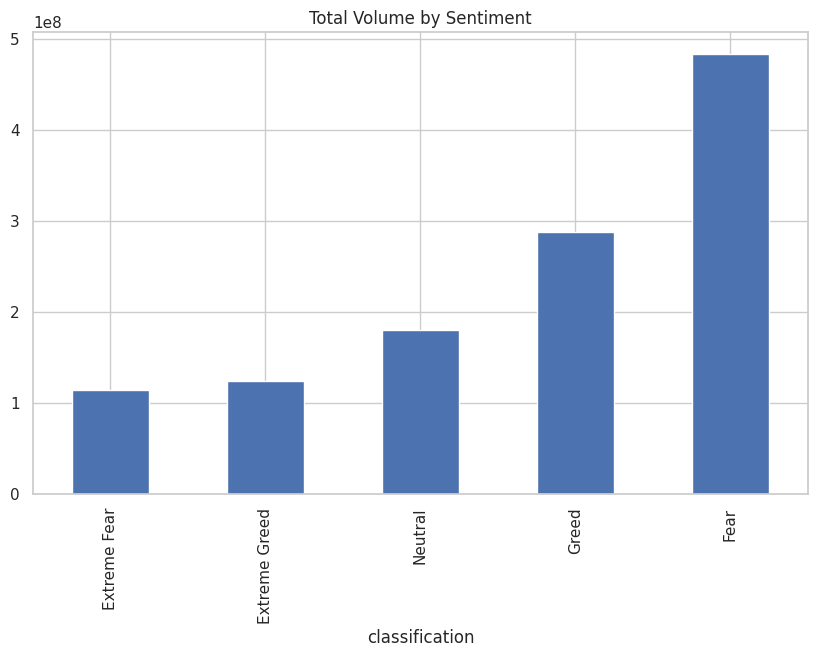

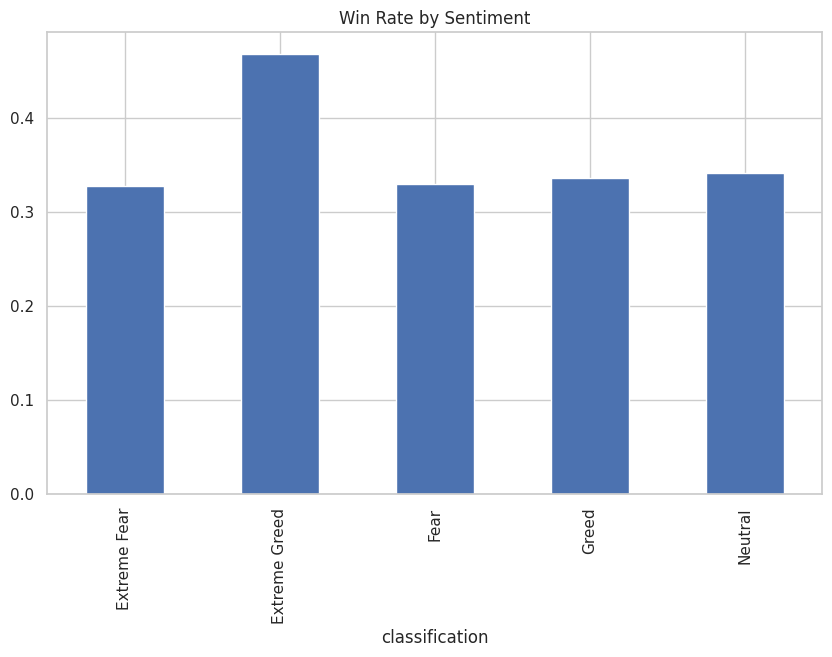

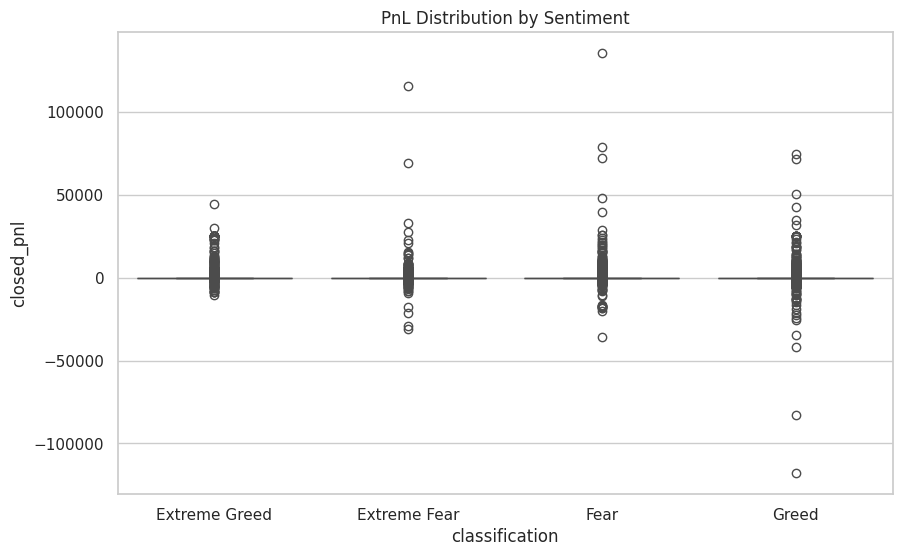

In [ ]:
# Volume by sentiment
plt.figure()
daily.groupby('classification')['volume'].sum().sort_values().plot(kind='bar')
plt.title("Total Volume by Sentiment")
plt.savefig("outputs/volume_by_sentiment.png")
plt.show()

# Win rate by sentiment
plt.figure()
daily.groupby('classification')['win_rate'].mean().plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.savefig("outputs/winrate_by_sentiment.png")
plt.show()

# PnL distribution
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['classification']!='Neutral'], x='classification', y='closed_pnl')
plt.title("PnL Distribution by Sentiment")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.show()

# Top 10 traders by sentiment
for label in ['Fear','Greed','Extreme Fear','Extreme Greed','Neutral']:
    subset = trader_sent[trader_sent['classification']==label]
    if subset.empty:
        continue
    top10 = subset.sort_values('total_pnl', ascending=False).head(10)
    top10.to_csv(f"csv_files/top_traders_{label.replace(' ','_').lower()}.csv", index=False)


In [ ]:
# T-test Fear vs Greed
fear = df[df['classification']=='Fear']['closed_pnl'].dropna()
greed = df[df['classification']=='Greed']['closed_pnl'].dropna()

if len(fear)>5 and len(greed)>5:
    t_stat, p_val = ttest_ind(fear, greed, equal_var=False)
    print("T-test Fear vs Greed:", t_stat, p_val)
else:
    print("Not enough rows for t-test.")

# Chi-square on profitability
ct = pd.crosstab(df['classification'], df['is_profitable'])

if ct.shape[0] >= 2 and ct.shape[1] >= 2:
    chi2, p, dof, exp = chi2_contingency(ct)
    print("Chi-square:", chi2, "p:", p)
else:
    print("Not enough rows for chi-square.")


T-test Fear vs Greed: 1.8511431575014454 0.06415196288057486
Chi-square: 821.5683541886879 p: 1.634437392523828e-176


In [ ]:
model_df = df.copy()

model_df['sentiment_label'] = model_df['classification'].map({
    'Fear':0,'Neutral':1,'Greed':2,'Extreme Fear':3,'Extreme Greed':4
})

model_df = model_df.dropna(subset=['notional','size','execution_price','sentiment_label','is_profitable'])

X = model_df[['notional','size','execution_price','sentiment_label']]
y = model_df['is_profitable'].astype(int)

if len(y.unique()) < 2:
    print("Not enough classes for classification.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)[:,1]

    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, probs))

    importances = pd.Series(clf.feature_importances_, index=X.columns)
    importances.to_csv("csv_files/classifier_feature_importances.csv")
    display(importances)


              precision    recall  f1-score   support

           0       0.81      0.86      0.84     24802
           1       0.78      0.72      0.75     17443

    accuracy                           0.80     42245
   macro avg       0.80      0.79      0.79     42245
weighted avg       0.80      0.80      0.80     42245

ROC AUC: 0.8847818539839485


,0
notional,0.232399
size,0.232892
execution_price,0.491930
sentiment_label,0.042779


In [ ]:
reg = daily.dropna(subset=['pnl_sum'])

features = ['trade_count','volume','avg_trade_size','avg_abs_pnl','win_rate','pnl_volatility']
Xr = reg[features].fillna(0)
yr = reg['pnl_sum']

X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=200, random_state=42)
rfr.fit(X_train, y_train)

predr = rfr.predict(X_test)

mse = mean_squared_error(y_test, predr)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

reg_importances = pd.Series(rfr.feature_importances_, index=features)
reg_importances.to_csv("csv_files/regressor_feature_importances.csv")
display(reg_importances)


MSE: 5283195999.926322
RMSE: 72685.59692212979


,0
trade_count,0.302131
volume,0.052897
avg_trade_size,0.046134
avg_abs_pnl,0.192034
win_rate,0.059023
pnl_volatility,0.347781
